* **Name: Magnus Aghe** 
* **Student ID: 900400010** 
* **Email: m.aghe0010@student.nu.edu** 
* **Course: ANA680 - MODULE 2 - BREAST CANCER PREDICTION - ASSIGNMENT**

**Task**

To select the algorithm that produced the best result (accuracy) in Module 1 assignment, retrain the model using this algorithm with the top four relevant features and save the model as a pickle file.

**Selected Algorithm**

From Module 1 assignment, **Kernel SVM** had the best accuracy of the eight models, with 0.94287 accuracy and 56 True Positive. **Therefore Kernel SVM is our selected model.**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
# Loading the dataset

df=pd.read_csv("breast-cancer-wisconsin-data1.csv", na_values=['NULL', '?', 'NONE'])

**Exploring and Cleaning the Dataset**

In [4]:
df.shape

(699, 11)

The dataset has 699 rows and 11 columns

In [5]:
df.head(5)

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [6]:
df.info

<bound method DataFrame.info of           ID  clump_thickness  uniformity_cell_size  uniformity_cell_shape  \
0    1000025                5                     1                      1   
1    1002945                5                     4                      4   
2    1015425                3                     1                      1   
3    1016277                6                     8                      8   
4    1017023                4                     1                      1   
..       ...              ...                   ...                    ...   
694   776715                3                     1                      1   
695   841769                2                     1                      1   
696   888820                5                    10                     10   
697   897471                4                     8                      6   
698   897471                4                     8                      8   

     marginal_adhesion  single_

In [7]:
# Listing the column names

df.columns

Index(['ID', 'clump_thickness', 'uniformity_cell_size',
       'uniformity_cell_shape', 'marginal_adhesion', 'single_epi_cell_size',
       'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses',
       'class'],
      dtype='object')

In [8]:
# Listing categorical features

df.select_dtypes(include=['object']).columns

Index([], dtype='object')

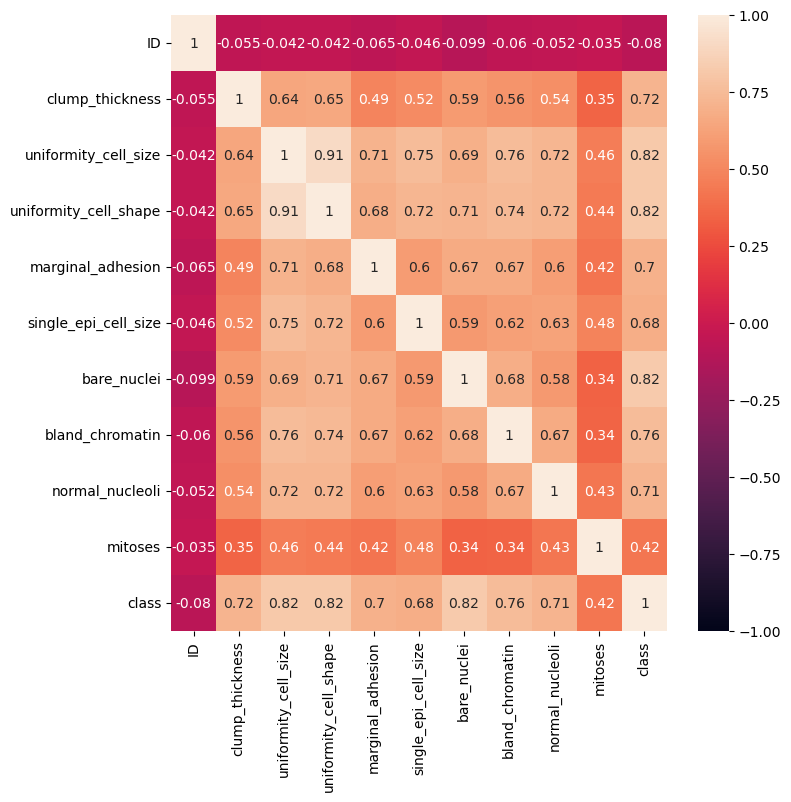

In [9]:
# Using correlation matrix and heatmap for feature selection

corr=df.corr()
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.show()

In [10]:
tumorclass_corr = df.corr()
print(tumorclass_corr['class'].sort_values(ascending=False)) 

class                    1.000000
bare_nuclei              0.822696
uniformity_cell_shape    0.818934
uniformity_cell_size     0.817904
bland_chromatin          0.756616
clump_thickness          0.716001
normal_nucleoli          0.712244
marginal_adhesion        0.696800
single_epi_cell_size     0.682785
mitoses                  0.423170
ID                      -0.080226
Name: class, dtype: float64


We shall be using as our predictors, the four features that have the most correlation with class. They are bare_nuclei, uniformity_cell_shape, uniformity_cell_size, and bland_chromatin.

In [11]:
df.dtypes

ID                         int64
clump_thickness            int64
uniformity_cell_size       int64
uniformity_cell_shape      int64
marginal_adhesion          int64
single_epi_cell_size       int64
bare_nuclei              float64
bland_chromatin            int64
normal_nucleoli            int64
mitoses                    int64
class                      int64
dtype: object

In [12]:
# Converting 'class' to categorical and 'ID' as object

df['class'] = df['class'].astype('category')
df['ID'] = df['ID'].astype('object')

In [13]:
df.select_dtypes(include=['object']).columns

Index(['ID'], dtype='object')

In [14]:
# Listing numerical features and their statistical description

df.select_dtypes(exclude=['object']).describe().round(decimals=2).transpose()

,count,mean,std,min,25%,50%,75%,max
clump_thickness,699.0,4.42,2.82,1.0,2.0,4.0,6.0,10.0
uniformity_cell_size,699.0,3.13,3.05,1.0,1.0,1.0,5.0,10.0
uniformity_cell_shape,699.0,3.21,2.97,1.0,1.0,1.0,5.0,10.0
marginal_adhesion,699.0,2.81,2.86,1.0,1.0,1.0,4.0,10.0
single_epi_cell_size,699.0,3.22,2.21,1.0,2.0,2.0,4.0,10.0
bare_nuclei,683.0,3.54,3.64,1.0,1.0,1.0,6.0,10.0
bland_chromatin,699.0,3.44,2.44,1.0,2.0,3.0,5.0,10.0
normal_nucleoli,699.0,2.87,3.05,1.0,1.0,1.0,4.0,10.0
mitoses,699.0,1.59,1.72,1.0,1.0,1.0,1.0,10.0


In [15]:
# Checking for missing values

print ('Number of bare_nuclei missing values : ', df.bare_nuclei.isnull().sum())

Number of bare_nuclei missing values :  16


In [16]:
# We shall replace the bare_nuclei missing values using the mean of the remaining values.

meanbare_nuclei = df['bare_nuclei'].mean()
df.bare_nuclei = df.bare_nuclei.fillna(value=meanbare_nuclei)
print('Number of rows with valid bare_nuclei values after filling NA values: ',
       df['bare_nuclei'].count())

Number of rows with valid bare_nuclei values after filling NA values:  699


All features now have the same count size of 699 

In [17]:
# Number of values in the "class" categorical feature

df['class'].value_counts()

2    458
4    241
Name: class, dtype: int64

458 patients have benign tumor, while 241 have malignant tumor

In [18]:
# Summing up the count size of 'class'

df['class'].value_counts().sum()

699

'class' has a total of 699 counts. 

In [19]:
# Let's map the class categorical values to its actual meaning 
df['class'] = df['class'].map({2:'Benign', 4:'Malignant'})
df

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,Benign
1,1002945,5,4,4,5,7,10.0,3,2,1,Benign
2,1015425,3,1,1,1,2,2.0,3,1,1,Benign
3,1016277,6,8,8,1,3,4.0,3,7,1,Benign
4,1017023,4,1,1,3,2,1.0,3,1,1,Benign
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2.0,1,1,1,Benign
695,841769,2,1,1,1,2,1.0,1,1,1,Benign
696,888820,5,10,10,3,7,3.0,8,10,2,Malignant
697,897471,4,8,6,4,3,4.0,10,6,1,Malignant


**Building the Classification Models**

In [20]:
# let's examine the cleaned/transformed dataset

df.head()

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1.0,3,1,1,Benign
1,1002945,5,4,4,5,7,10.0,3,2,1,Benign
2,1015425,3,1,1,1,2,2.0,3,1,1,Benign
3,1016277,6,8,8,1,3,4.0,3,7,1,Benign
4,1017023,4,1,1,3,2,1.0,3,1,1,Benign


In [21]:
# Selecting predictor and target variables

X = df[['bare_nuclei', 'uniformity_cell_size', 'uniformity_cell_shape', 'bland_chromatin']]
Y = df['class']

In [22]:
# Splitting the dataset such that the test data size is 25% of the total dataset


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

**Kernel SVM Model**

In [23]:
# Training the model and predicting on test data

rsvm = SVC(kernel = 'rbf', random_state = 0)  
rsvm.fit(X_train, y_train.ravel())
y_pred = rsvm.predict(X_test)

print("Kernel SVM")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred, target_names=['Benign','Malignant']))

Kernel SVM
Accuracy: 0.9428571428571428
Confusion Matrix:
[[109   5]
 [  5  56]]

              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96       114
   Malignant       0.92      0.92      0.92        61

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



In [24]:
import pickle
# Open a file and use dump() 
with open('file_breastcancer.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(rsvm, file)